In [1]:
import numpy as np
import pandas as pd
import os
from typing import List, Optional, Dict
import gc
import missingno as msno
import matplotlib.pyplot as plt
import math
from scipy import stats

# Set precision to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

### Data Read

In [2]:
def read_parquet(input_dir: str, years: Optional[List[int]] = None) -> Dict[int, pd.DataFrame]:
    """
    Reads Parquet files for specified years from the input directory.

    Args:
        input_dir (str): The directory where Parquet files are stored.
        years (Optional[List[int]]): A list of years to read. If None, read all available years.

    Returns:
        Dict[int, pd.DataFrame]: A dictionary with years as keys and pandas DataFrames as values.
    """
    data_frames = {}
    available_years = [int(d.split('=')[1]) for d in os.listdir(input_dir) if d.startswith('year=')]
    years_to_read = years if years is not None else available_years

    for year in years_to_read:
        year_path = os.path.join(input_dir, f'year={year}')
        if os.path.exists(year_path):
            df = pd.read_parquet(year_path)
            df['year'] = year  # Add the year column 
            data_frames[year] = df
        else:
            print(f"Warning: No data found for year {year}")

    return data_frames

In [3]:
years = [2015, 2016, 2017, 2018, 2019] 
output_directory = "../data/DS/NSDUH"

# Read saved data 
df = pd.concat(read_parquet(output_directory, years).values())   
        

## Sharan Raj Sivakumar Hypothesis

### Hypothesis 1: Early drug use, particularly during adolescence, is a risk factor for the development of mental health issues. 
#### Null Hypothesis: There is no relationship between early drug use and the development of mental health issues.
#### Alternative Hypothesis: Early drug use is associated with an increased risk of developing mental health issues.

In [4]:
identity_columns_H1 = ['QUESTID2']
# drug_usage_columns_H1 = ['MJEVER','MJAGE', 'BLNTEVER', 'BLNTAGE','COCEVER', 'COCAGE', 'CRKEVER', 'CRKAGE', 'HEREVER', 'HERAGE', 'HALLUCEVR','HALLUCAGE', 'METHAMEVR', 'METHAMAGE']

drug_usage_columns_H1 = ['MJAGE', 'BLNTAGE', 'COCAGE',  'CRKAGE',  'HERAGE', 'HALLUCAGE', 'METHAMAGE']


mental_health_columns_H1 = ['YMDELT']

columns_of_interest_H1 = identity_columns_H1 + drug_usage_columns_H1 + mental_health_columns_H1


In [5]:
# Creating a copy of df for Hypothesis 2 analysis
df_H1 = df[columns_of_interest_H1].copy()

In [6]:
# Get unique values for each column
for column in df_H1.columns:
    unique_values = df_H1[column].unique()
    print(f"\nUnique values for {column}:")
    print(unique_values)


Unique values for QUESTID2:
[25095143 13005143 67415143 ... 38044730 43164730 92074730]

Unique values for MJAGE:
[991  15  14  18 985  12  21  24  17  13  22  35  16  20  19  23  25  36
  38 994   7  30  32   9  11  29  10  27  28  26  31  39   8  37  55  40
  45  34  51  50 998  44  76 997  48  42   5  56  52   6   2  47  43   3
  33   4  54  49  58  72  65  46  57  64  69  62  60  75   1  77  41  78
  74  68  53  61  66  71  67  59  80  63  70  81  79  73  82]

Unique values for BLNTAGE:
[991  26  16  21  14  15 994  18  17  35  19  20  12  13  22  40  36  30
  25  10  23  34  45   6  28  11  56   8  29  24  38  42 997  27  54  32
  31  60  47 981 998   9  55  50   7  37   2  49  48  59  43  53   1  46
 985  33   3  44  41  58  39  52  57  65  51   5  62  66   4  61  63  76
  68  73  64  70  69]

Unique values for COCAGE:
[991  16  13  20  15  24  18  34  19  25  22  17  14  21  27  23  26  12
  50  35  30  37  29  36  28  31 994  38  48 997  39  40  33  32  11 985
   2  55  45 998

In [7]:
# Clean the data
df_H1 = df_H1.drop_duplicates()  # Remove duplicates

In [8]:
df_H1[drug_usage_columns_H1+mental_health_columns_H1].describe()

,MJAGE,BLNTAGE,COCAGE,CRKAGE,HERAGE,HALLUCAGE,METHAMAGE,YMDELT
count,281835.00,281835.00,281835.00,281835.00,281835.00,281835.00,281835.00,66390.00
mean,575.25,763.95,877.24,965.19,974.43,851.72,947.53,1.80
std,481.69,411.66,312.15,155.91,125.60,340.62,200.71,0.40
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,17.00,991.00,991.00,991.00,991.00,991.00,991.00,2.00
50%,991.00,991.00,991.00,991.00,991.00,991.00,991.00,2.00
75%,991.00,991.00,991.00,991.00,991.00,991.00,991.00,2.00
max,998.00,998.00,998.00,998.00,998.00,998.00,998.00,2.00


In [9]:
# Define a dictionary for replacements based on the code conventions
code_replacements = {
    93: np.nan,
    993: np.nan,
    9993: np.nan,
    94: np.nan,  # Don't Know
    994: np.nan,
    9994: np.nan,
    97: np.nan,  # Refused
    997: np.nan,
    9997: np.nan,
    98: np.nan,  # Blank
    998: np.nan,
    9998: np.nan,
    99: np.nan,  # Legitimate Skip
    999: np.nan,
    9999: np.nan,
    89: np.nan,  
    989: np.nan,
    9989: np.nan,
    85: np.nan, # Bad data
    985: np.nan,
    9985: np.nan
}

# Apply the replacements to the DataFrame
df_H1.replace(code_replacements, inplace=True)

# Drop rows with missing values
df_H1.dropna(inplace=True)

In [10]:
# Convert all to integer
df_H1 = df_H1.astype(int)

In [11]:
# Get unique values for each column
for column in df_H1.columns:
    unique_values = df_H1[column].unique()
    print(f"\nUnique values for {column}:")
    print(unique_values)


Unique values for QUESTID2:
[25095143 70925143 63765143 ... 38044730 43164730 92074730]

Unique values for MJAGE:
[991  14  12  15  17  16  13  11   9  10   8   5   7   2   6   1   3   4]

Unique values for BLNTAGE:
[991  16  14  15  17  12  13  10   8   6 981   7  11   9   1   2   5   3
   4]

Unique values for COCAGE:
[991  15  14  16  17  12  13  10   8   7   9  11   1   6]

Unique values for CRKAGE:
[991  14  15  13  12   8  17  16  11   6]

Unique values for HERAGE:
[991  15  14  13  12   9  16  17  11   5  10]

Unique values for HALLUCAGE:
[991  14  15  17  12  13  16   2   1  10  11   9   8   6   7   4   5]

Unique values for METHAMAGE:
[991  14  15  12  16  17  10  11   9  13   1   8   5   2   6]

Unique values for YMDELT:
[1 2]


In [12]:
# Condition for never used drugs
never_used_condition = (df_H1 == 991) | (df_H1 == 981)

# DataFrame for no drug use
no_drug_use_df = df_H1[never_used_condition[drug_usage_columns_H1].all(axis=1)]
no_drug_use_df["Drug_Use"] = 0

# DataFrame for any drug use
any_drug_use_df = df_H1[~never_used_condition[drug_usage_columns_H1].all(axis=1)]
any_drug_use_df["Drug_Use"] = 1

df_H1 = pd.concat([no_drug_use_df,any_drug_use_df])

# Add a binary column for drug use
# df_H1['Drug_Use'] = ~(df_H1 == 991).all(axis=1) & ~(df_H1 == 981).all(axis=1)


print(f"No Drug Use DataFrame Shape:{df_H1[df_H1['Drug_Use']==0].shape}")

print(f"Any Drug Use DataFrame Shape:{df_H1[df_H1['Drug_Use']==1].shape}")

No Drug Use DataFrame Shape:(53755, 10)
Any Drug Use DataFrame Shape:(11040, 10)


In [13]:
# Hypothesis Test
t_stat, p_value = stats.ttest_ind(no_drug_use_df['YMDELT'].dropna(), any_drug_use_df['YMDELT'].dropna())

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 43.34074470538926
P-value: 0.0


### Interpretation of Results:

- **T-statistic**: 43.341  
  A **T-statistic** of 43.341 is very large. This indicates that the difference between early drug users and non-drug users (in terms of developing mental health issues) is much greater than what would be expected under the null hypothesis. In other words, this large T-value suggests a strong association between early drug use and the development of mental health issues.

- **P-value**: 0.0  
  A **P-value** of 0.0 (or something extremely close to 0) indicates that the likelihood of observing this data if the null hypothesis were true (i.e., if there really is no association between early drug use and mental health issues) is virtually **zero**.

---

### Conclusion:
- Given the very high T-statistic and the P-value of 0.0, you would **reject the null hypothesis** with great confidence.
- There is very strong evidence to suggest that early drug use, particularly during adolescence, is a significant risk factor for the development of mental health issues.
- The result implies that the observed relationship is not due to random chance but is likely a true effect in the population.

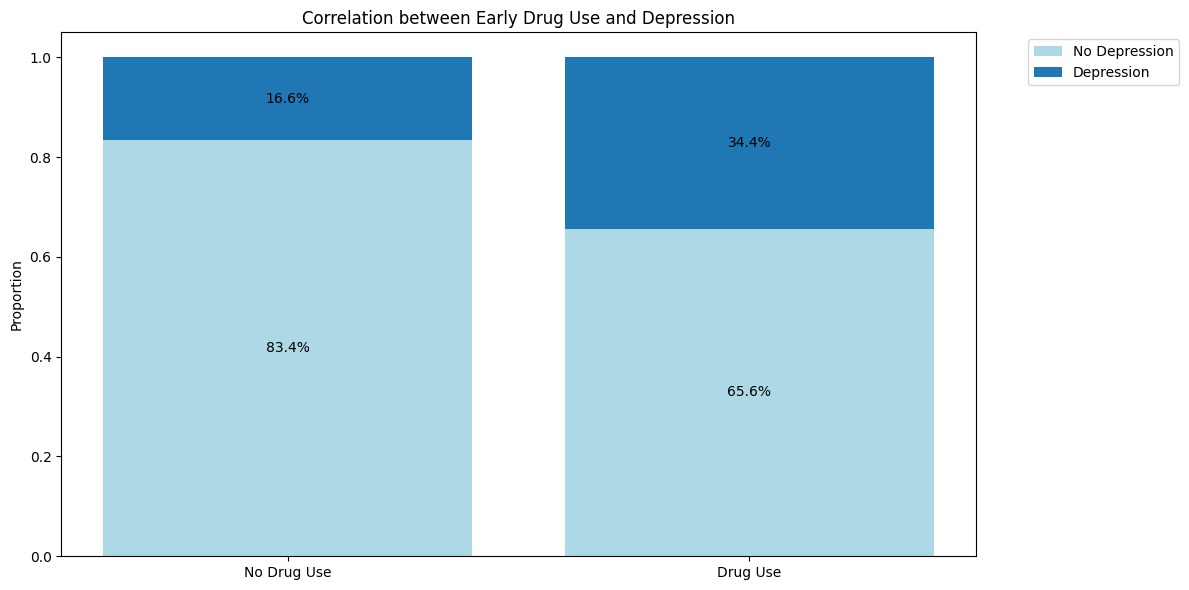

In [14]:
# Calculate the proportions
drug_use_0 = df_H1[df_H1['Drug_Use'] == 0]['YMDELT'].value_counts(normalize=True)
drug_use_1 = df_H1[df_H1['Drug_Use'] == 1]['YMDELT'].value_counts(normalize=True)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

labels = ['No Drug Use', 'Drug Use']
no_depression = [drug_use_0.get(2, 0), drug_use_1.get(2, 0)]
depression = [drug_use_0.get(1, 0), drug_use_1.get(1, 0)]

ax.bar(labels, no_depression, label='No Depression', color='lightblue')
ax.bar(labels, depression, bottom=no_depression, label='Depression')

ax.set_ylabel('Proportion')
ax.set_title('Correlation between Early Drug Use and Depression')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels on the bars
for i, (no_dep, dep) in enumerate(zip(no_depression, depression)):
    ax.text(i, no_dep/2, f'{no_dep:.1%}', ha='center', va='center')
    ax.text(i, no_dep + dep/2, f'{dep:.1%}', ha='center', va='center')

plt.tight_layout()
plt.show()

### Key Observations:

1. **No Drug Use Group**:
   - **83.4%** of individuals who did not use drugs early are not depressed.
   - **16.6%** of individuals in the "No Drug Use" group suffer from depression.

2. **Drug Use Group**:
   - **65.6%** of individuals who used drugs early are not depressed.
   - **34.4%** of individuals in the "Drug Use" group suffer from depression.

---

### Interpretation:
- **Higher Depression in Drug Users**: The proportion of individuals with depression is notably higher in the "Drug Use" group (**34.4%**) compared to the "No Drug Use" group (**16.6%**).
- **Lower Depression in Non-Drug Users**: Conversely, individuals who did not engage in early drug use show a much higher rate of being non-depressed (**83.4%**) compared to the "Drug Use" group (**65.6%**).

---

### Conclusion:
The chart visually supports the hypothesis that early drug use is associated with a higher likelihood of developing depression. There is a clear difference between the two groups, with a higher proportion of depression among those who used drugs early in life. This suggests that early drug use could be a risk factor for depression, as the relationship is clearly visible in the data.

### Hypothesis 2: Individuals who are married or widowed are less likely to experience suicidal thoughts compared to individuals who are single. 
#### Null Hypothesis: There is no relationship between being marital status and experiencing suicidal thoughts.
#### Alternative Hypothesis: Married or widowed individuals have lesser chance of experiencing suicidal thoughts 

In [15]:
identity_columns_H2 = ['QUESTID2']

independent_columns_H2 = ['IRMARIT']

dependent_columns_H2 = ['SUICTHNK']

columns_of_interest_H2 = identity_columns_H2 + independent_columns_H2 + dependent_columns_H2


In [16]:
# Creating a copy of df for Hypothesis 3 analysis
df_H2 = df[columns_of_interest_H2].copy()

In [17]:
# Get unique values for each column
for column in df_H2.columns:
    if column not in identity_columns_H2:
        unique_values = df_H2[column].unique()
        print(f"\nUnique values for {column}:")
        print(unique_values)


Unique values for IRMARIT:
[nan  1.  4.  2. 99.  3.]

Unique values for SUICTHNK:
[99  2 94 97  1 85 98 89]


In [18]:
# Clean the data
df_H2 = df_H2.drop_duplicates()  # Remove duplicates

In [19]:
df_H2[independent_columns_H2+dependent_columns_H2].describe()

,IRMARIT,SUICTHNK
count,224857.00,282003.00
mean,14.22,25.92
std,31.14,41.85
min,1.00,1.00
25%,1.00,2.00
50%,4.00,2.00
75%,4.00,2.00
max,99.00,99.00


In [20]:
# Define a dictionary for replacements based on the code conventions for IRMARIT
code_replacements = {1:"Married", 2:"Widowed", 3:np.nan, 4:"Single", 99: np.nan}


# Apply the replacements to the DataFrame
df_H2["IRMARIT"].replace(code_replacements, inplace=True)


# Define a dictionary for replacements based on the code conventions for SUICTHNK
code_replacements = {85:np.nan, 89:np.nan, 94:np.nan, 97:np.nan, 98:np.nan, 99: np.nan}

# Apply the replacements to the DataFrame
df_H2["SUICTHNK"].replace(code_replacements, inplace=True)

# Drop rows with missing values
df_H2.dropna(inplace=True)

In [21]:
# Convert all to integer
df_H2["SUICTHNK"] = df_H2["SUICTHNK"].astype(int)

In [22]:
# Get unique values for each column
for column in df_H2.columns:
    if column not in identity_columns_H2:
        unique_values = df_H2[column].unique()
        print(f"\nUnique values for {column}:")
        print(unique_values)


Unique values for IRMARIT:
['Married' 'Single' 'Widowed']

Unique values for SUICTHNK:
[2 1]


In [23]:
single_df_H2 = df_H2[df_H2["IRMARIT"]=="Single"]
not_single_df_H2 = df_H2[df_H2["IRMARIT"]!="Single"]


In [24]:
# Hypothesis Test
t_stat, p_value = stats.ttest_ind(not_single_df_H2['SUICTHNK'], single_df_H2["SUICTHNK"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 50.2948528555206
P-value: 0.0


### Results:
- **T-statistic**: 50.295  
  A **T-statistic** of 50.295 is extremely high, indicating a significant difference between the two groups regarding suicidal thoughts. This suggests that the observed data deviate greatly from what would be expected under the null hypothesis.

- **P-value**: 0.0  
  A **P-value** of 0.0 (or very close to it) indicates that the probability of observing such extreme results, assuming the null hypothesis is true, is virtually zero. This strongly suggests that the null hypothesis can be rejected.

---

### Conclusion:
Given the very high T-statistic and the P-value of 0.0, we can confidently **reject the null hypothesis**. There is compelling evidence to support the alternative hypothesis that individuals who are single are significantly more likely to experience suicidal thoughts compared to those who are married or widowed. This result highlights the potential individuals enjoy a sense of companionship(present or former) contributes positively to their happiness.

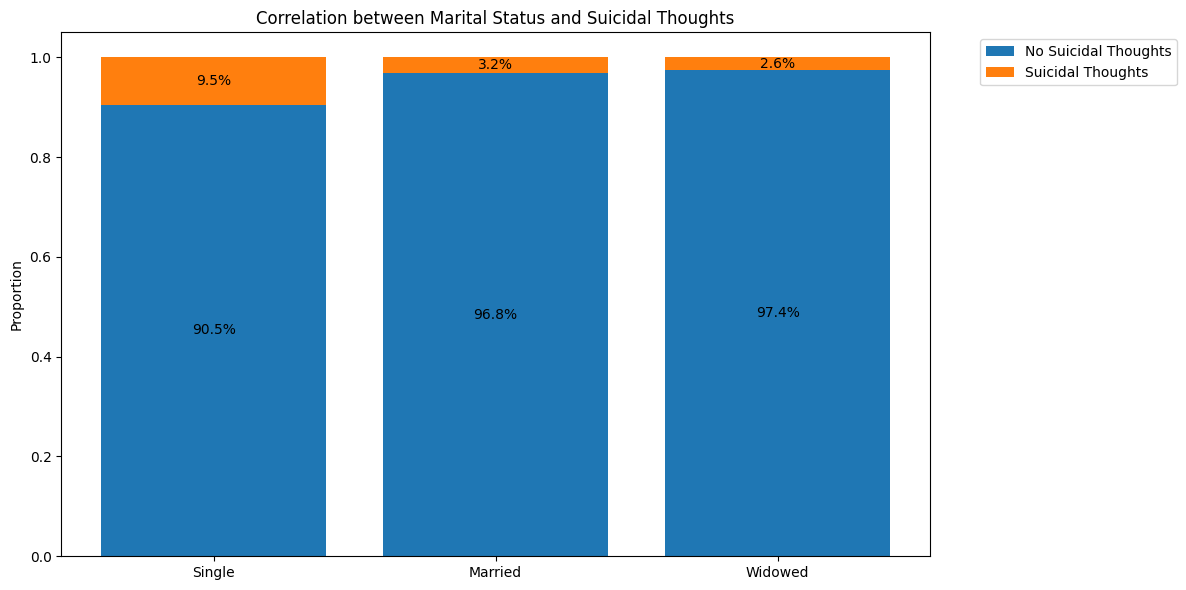

In [25]:
# Calculate the proportions for each marital status
marital_status_0 = df_H2[df_H2['IRMARIT'] == 'Single']['SUICTHNK'].value_counts(normalize=True)
marital_status_1 = df_H2[df_H2['IRMARIT'] == 'Married']['SUICTHNK'].value_counts(normalize=True)
marital_status_2 = df_H2[df_H2['IRMARIT'] == 'Widowed']['SUICTHNK'].value_counts(normalize=True)


# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

labels = ['Single', 'Married', 'Widowed']
no_suicidal_thoughts = [
    marital_status_0.get(2, 0),  # No for Single
    marital_status_1.get(2, 0),  # No for Marriage
    marital_status_2.get(2, 0),  # No for Widowed
]
suicidal_thoughts = [
    marital_status_0.get(1, 0),  # Yes for Single
    marital_status_1.get(1, 0),  # Yes for Marriage
    marital_status_2.get(1, 0),  # Yes for Widowed
]

ax.bar(labels, no_suicidal_thoughts, label='No Suicidal Thoughts')
ax.bar(labels, suicidal_thoughts, bottom=no_suicidal_thoughts, label='Suicidal Thoughts')

ax.set_ylabel('Proportion')
ax.set_title('Correlation between Marital Status and Suicidal Thoughts')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels on the bars
for i, (no_suicidal, suicidal) in enumerate(zip(no_suicidal_thoughts, suicidal_thoughts)):
    ax.text(i, no_suicidal / 2, f'{no_suicidal:.1%}', ha='center', va='center')
    ax.text(i, no_suicidal + suicidal / 2, f'{suicidal:.1%}', ha='center', va='center')

plt.tight_layout()
plt.show()


### Key Observations:

1. **Single Individuals**:
   - **90.5%** of single individuals donot experience having suicidal thoughts.
   - **9.5%** of single individuals experience suicidal thoughts.

2. **Married Individuals**:
   - **96.8%** of married individuals donot experience having suicidal thoughts.
   - **3.2%** of married individuals experience suicidal thoughts.

3. **Widowed Individuals**:
   - **97.4%** of widowed individuals donot experience having suicidal thoughts.
   - **2.6%** of widowed individuals experience suicidal thoughts.

---

### Interpretation:
- **Higher Suicidal Thoughts in Single Individuals**: The proportion of individuals reporting suicidal thoughts is significantly higher in singles compared to married and widowed individual.
---

### Conclusion:
The chart visually supports the hypothesis that marital status is associated with the likelihood of experiencing suicidal thoughts. The data reveals a clear trend, with single individuals showing a higher proportion of suicidal thoughts compared to their married and widowed counterparts. Though Singles do experience higher suicidal thoughts we need to consider other socio-economic factors to further classify since the difference in percentages is less than 7%


## Data cleaning steps done during Hypothesis

## 1. Handling Sparse Columns
- **Goal**: Identify columns with sparse data and remove or address them.
- **Method**: Columns with more than 10% missing values were considered sparse. 

## 2. Removing Columns with Large Missing Values
- **Goal**: Improve data quality by eliminating columns with excessive missing data.
- **Method**: Any column with a significant portion (over 10%) of missing values was identified from the dataset.

## 3. Filtering for Necessary Columns
- **Goal**: Retain only the relevant columns for analysis.
- **Method**: Non-essential columns were filtered out, leaving only those pertinent to the analysis and model-building steps.

## 4. Type Correction
- **Goal**: Ensure that each column's data type is appropriate for its contents.
- **Method**: The data types of each column were reviewed and corrected where necessary. For example, converting strings representing dates into datetime objects, or strings containing numeric data into integers/floats.

## 5. Duplicate Record Removal
- **Goal**: Eliminate redundant entries that could distort analysis.
- **Method**: Identify and remove duplicate rows to ensure each record is unique.


## 6. Handling Missing Data
- **Goal**: Handle/impute missing Data
- **Method**: Imputed Missing data.


# Phase 2

#### a) Identify suitable ML, MR, and/or statistical modeling algorithms.
#### b) Apply these algorithms to gain insights into the data behavior.
#### c) Understand and explain the differences between the algorithms used.
#### d) Visualize the analytics using appropriate charts and graphs.

In [26]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns


### Model 1: Logistic Regression

Accuracy: 0.8044
ROC AUC: 0.5750

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     10425
           1       0.33      0.00      0.00      2534

    accuracy                           0.80     12959
   macro avg       0.57      0.50      0.45     12959
weighted avg       0.71      0.80      0.72     12959



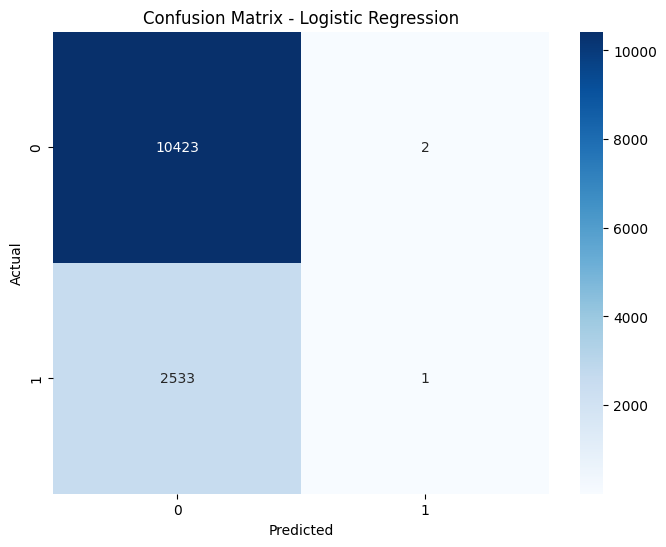

In [27]:

X = df_H1[drug_usage_columns_H1 + ['Drug_Use']]
y = df_H1['YMDELT'].replace({2: 0}) # No Depression label is transformed as 0 for Model training

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)


y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Accuracy and Classification Report
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Observations from Model 1

### **Overall Accuracy:**
- **Accuracy: 0.80**  
  This means that 80% of the predictions made by the model are correct. 

### **Key Observations:**
1. **Class Imbalance:** There is a significant imbalance between classes (10626 instances of class 0 vs. only 2636 instances of class 1). This imbalance is likely contributing to the poor performance on class 1.
2. **Poor Minority Class Performance:** The model struggles heavily with detecting instances of class 1, as shown by its very low recall and precission
3. **High Accuracy but Misleading:** While the accuracy is relatively high at 80%, it’s misleading due to the severe imbalance in prediction quality between classes.

### Model 2: XGBoost

Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     10626
           1       0.48      0.01      0.03      2636

    accuracy                           0.80     13262
   macro avg       0.64      0.51      0.46     13262
weighted avg       0.74      0.80      0.72     13262



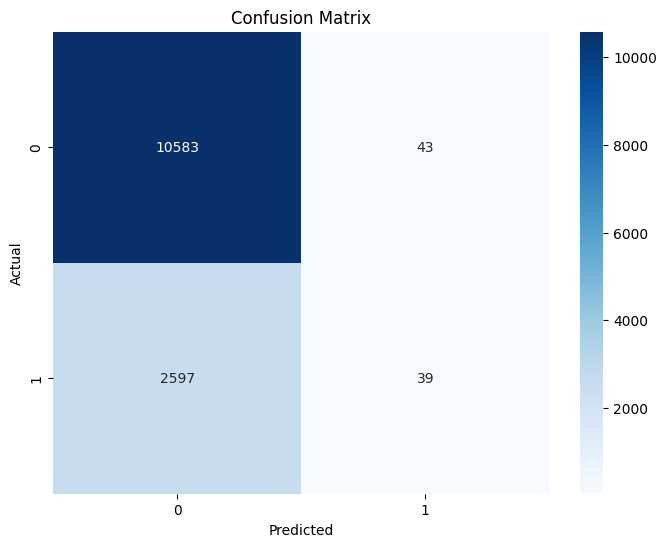

In [47]:
# Prepare the features and target
X = df_H1[drug_usage_columns_H1]
y = df_H1['YMDELT'].replace({2: 0}) # No Depression label is transformed as 0 for Model training

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create and train the XGBoost model
xgb_model = XGBClassifier(random_state=72, use_label_encoder=False)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Observations from Iteration 1

### **Overall Accuracy:**
- **Accuracy: 0.80**  
  This means that 80% of the predictions made by the model are correct. However, accuracy alone can be misleading, especially in cases of class imbalance, which seems to be present here (as indicated by the large difference in support between classes 0 and 1).

### **Key Observations:**
1. **Class Imbalance:** There is a significant imbalance between classes (10626 instances of class 0 vs. only 2636 instances of class 1). This imbalance is likely contributing to the poor performance on class 1.
2. **Poor Minority Class Performance:** The model struggles heavily with detecting instances of class 1, as shown by its very low recall (0.01) and F1-score (0.02). This suggests that the model is biased towards predicting the majority class (class 0).
3. **High Accuracy but Misleading:** While the accuracy is relatively high at 80%, it’s misleading due to the severe imbalance in prediction quality between classes.



### Model 2: XGBoost - Iteration 2

#### Balancing Data

In [28]:
df_H1['YMDELT'].value_counts()

YMDELT
2    52068
1    12727
Name: count, dtype: int64

In [29]:
df_H1_no = df_H1[df_H1['YMDELT']==2]
df_H1_yes = df_H1[df_H1['YMDELT']==1]

#Under sampling
df_H1_no = df_H1_no.sample(n=len(df_H1_yes), random_state=42)
df_H1_balanced = pd.concat([df_H1_no, df_H1_yes])

# Shuffling
df_H1_balanced = df_H1_balanced.sample(frac=1, random_state=42).reset_index(drop=True)



#### Using Additional Features

In [30]:
df_H1_balanced = df_H1_balanced.drop_duplicates(subset=identity_columns_H1)
df_H1_balanced.shape

(64653, 10)

In [37]:
drug_usage_columns_H1 = list(set(drug_usage_columns_H1) | {"Drug_Use"})
additional_columns_of_interest = ['MJEVER', 'BLNTEVER', 'COCEVER', 'CRKEVER', 'HEREVER', 'HALLUCEVR', 'METHAMEVR', 'YO_MDEA1', 'IRSEX']
df_H1_balanced = pd.merge(df_H1_balanced, df[identity_columns_H1+additional_columns_of_interest], how='inner', on=identity_columns_H1)

In [38]:
df_H1 = df_H1_new.copy()
df_H1.shape

(66307, 19)

#### Feature Engineering

In [39]:
df_H1_balanced['total_drugs_used'] = df_H1_balanced[['MJEVER', 'BLNTEVER', 'COCEVER', 'CRKEVER', 'HEREVER', 'HALLUCEVR', 'METHAMEVR']].apply(lambda x: sum(x != 991), axis=1)
df_H1_balanced['age_first_drug_use'] = df_H1_balanced[['MJAGE', 'BLNTAGE', 'COCAGE',  'CRKAGE',  'HERAGE', 'HALLUCAGE', 'METHAMAGE']].replace(991, np.inf).min(axis=1)
df_H1_balanced['age_first_drug_use'] = df_H1_balanced['age_first_drug_use'].replace(np.inf, 0)

#### Model Training 

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}
Best Cross-Validation Accuracy: 0.96
Test Accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2568
           1       0.95      0.99      0.97      2674

    accuracy                           0.97      5242
   macro avg       0.97      0.97      0.97      5242
weighted avg       0.97      0.97      0.97      5242



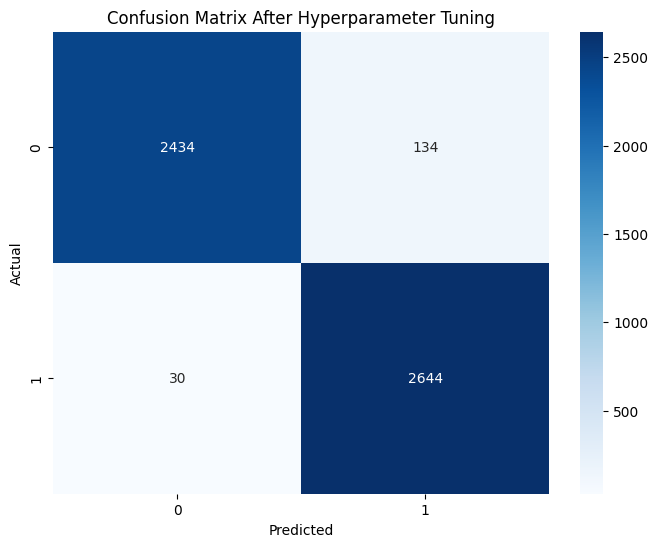

In [50]:
# Prepare the features and target
X = df_H1_balanced.drop(columns=identity_columns_H1+['YMDELT'])
y = df_H1_balanced['YMDELT'].replace({2: 0}) # No Depression label is transformed as 0 for Model training

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],            
    'max_depth': [3, 5, 7],                     
    'learning_rate': [0.01, 0.1, 0.2],         
    'subsample': [0.6, 0.8, 1.0],               
    'colsample_bytree': [0.6, 0.8, 1.0],        
    'gamma': [0, 0.1, 0.2],                     
    'min_child_weight': [1, 3, 5]               
}


# Create the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Set up GridSearchCV with cross-validation (cv=3)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='accuracy', cv=3, verbose=1)

# Fit the model to training data with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best parameters and best score from GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

# Use the best estimator to make predictions on the test set
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

# Evaluate the tuned model on test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix for the tuned model
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix After Hyperparameter Tuning')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



### **Observations from Iteration 2**

### **Overall Accuracy:**
- **Accuracy: 0.97**  
  This means that 97% of the predictions made by the model are correct.

### **Improvements done in Iteration 2:**
1. **Class Balancing:** Randomoly undersampled from the majority class(No Depression)
2. **Additional Features:** Utilised more features to improve underfitting
3. **Feature Engineering:** Created additional features from existing features
4. **Hyper Parameter Tuning**: Using GridSearch with cross-validation identified the best parameters as:

| Parameter | Value |
|-----------|-------|
| colsample_bytree | 0.8 |
| gamma | 0 |
| learning_rate | 0.01 |
| max_depth | 3 |
| min_child_weight | 1 |
| n_estimators | 300 |
| subsample | 1.0 |



### **Key Observations:**
1. Accuracy has increased from 80% to 97%.
2. Precision, Recall and F1-score has improved significantly.
3. This can be mainly attributed to the class balancing, Additional Features and Feature Engineering and the Hyperparameter tuning



#### Model Selection
XGBoost, with Balanced training data across classes, hyperparameter tuning, and Feature Engineering, performed superior to the previous iteration and models. 

XGBoost uses an ensemble of decision trees, which allows it to model intricate patterns than logistic regression but if classes are imbalanced even XGBoost perform at par with logistic regression. 

By addressing class imbalance, we ensured that the model had sufficient examples from all classes to learn from. This helps prevent bias towards the majority class and improves the performance on minority classes, leading to better overall prediction

Optimizing XGBoost's hyperparameters allowed us to fine-tune the model to our specific dataset. This process helps find the best combination of parameters like learning rate, tree depth, and number of estimators, which can significantly improve model performance

Creating new features and transforming existing ones provided the model with more informative inputs. This process can uncover hidden patterns in the data and make it easier for the model to learn relevant relationships, ultimately leading to better predictions

The conclusion drawn is that ML Engineering strategies are more or equally important as Model selection

**Choosen Model:** XGBoost, with Balanced training data across classes, hyperparameter tuning, and Feature Engineering, performed superior to the previous iteration and models. 

### Clustering

In [132]:
df_H2_new = pd.merge(df_H2, df[identity_columns_H1+["IRSEX", "NEWRACE2", "IRFAMIN3", "IRHHSIZ2"]],  how='inner', on=identity_columns_H1)


In [133]:
df_H2 = df_H2_new.drop_duplicates().copy()

In [134]:
df_H2 = df_H2.reset_index(drop=True)

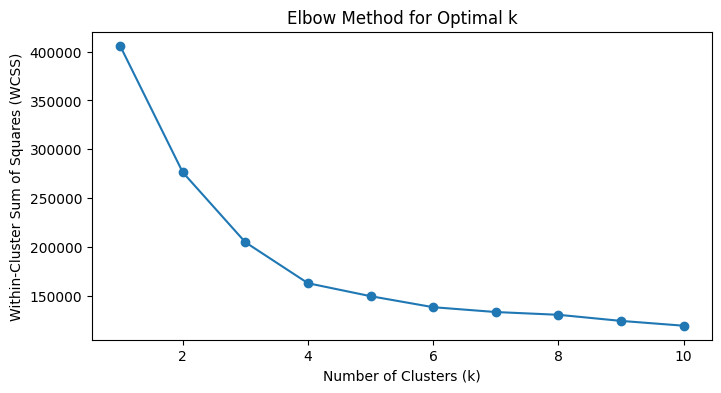

In [138]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Select relevant columns
columns = ["IRMARIT", "IRSEX", "NEWRACE2", "IRFAMIN3", "IRHHSIZ2"]

data = df_H2[columns]

# Define preprocessing steps
# One-hot encode categorical variables and standard scale numerical ones
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["IRFAMIN3", "IRHHSIZ2"]),
        ("cat", OneHotEncoder(drop="first"), [ "IRSEX", "NEWRACE2"])
    ]
)

X = preprocessor.fit_transform(data)

# Determine optimal number of clusters using the Elbow method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the WCSS to identify the elbow point
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.show()





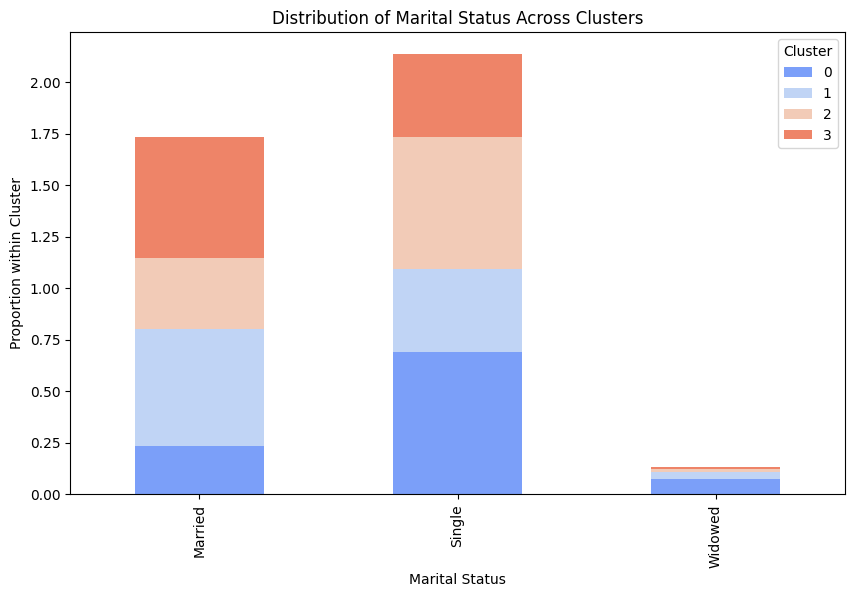

In [142]:
k = 4  # Adjust based on the optimal k found from the elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)

# Add the cluster labels to the original DataFrame
df_H2["Cluster"] = clusters

# Define a consistent color palette for the clusters
cluster_palette = sns.color_palette("coolwarm", n_colors=k)

# Analyze the distribution of marital status within each cluster
marital_cluster = pd.crosstab(df_H2["IRMARIT"], df_H2["Cluster"], normalize="columns")

# Plot the marital status distribution within clusters
marital_cluster.plot(kind="bar", stacked=True, color=cluster_palette, figsize=(10, 6))
plt.title("Distribution of Marital Status Across Clusters")
plt.xlabel("Marital Status")
plt.ylabel("Proportion within Cluster")
plt.legend(title="Cluster")
plt.show()



**Distribution of Marital Status Across Clusters**

The first visualization depicts the distribution of marital status (Married, Single, Widowed) across four clusters (0, 1, 2, 3). The y-axis represents the proportion of individuals within each cluster, while the x-axis shows the marital status categories.

* **Married:** The married individuals are distributed across all four clusters, with a relatively even distribution between clusters 0 and 1. Cluster 0 has a slightly higher proportion compared to others.
* **Single:** The single individuals are predominantly represented in clusters 0 and 1. Cluster 0 has the largest proportion of single individuals, followed by cluster 1. There is a smaller representation in clusters 2 and 3.
* **Widowed:** Widowed individuals are sparsely represented across all clusters. Cluster 0 has a small proportion of widowed individuals, with minimal representation in the other clusters.

This chart suggests that marital status plays a role in how individuals are grouped into different clusters. Single individuals are more concentrated in certain clusters (especially cluster 0), while widowed individuals have minimal representation across all clusters.

Proportion of Individuals with Suicidal Thoughts in Each Cluster:
Cluster
0   36.14
1   15.13
2   14.49
3   39.04
Name: SUICTHNK, dtype: float64


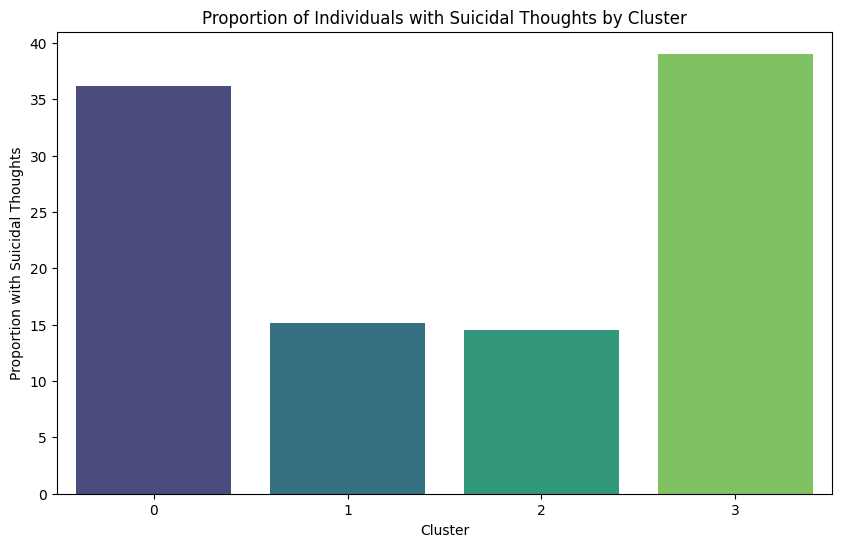

In [95]:
# Calculate the proportion of suicidal thoughts within each cluster
suicidal_distribution = df_H2.groupby("Cluster")["SUICTHNK"].max()

# Print the distribution for each cluster
print("Proportion of Individuals with Suicidal Thoughts in Each Cluster:")
print(suicidal_distribution)

# Visualize the proportion of suicidal thoughts in each cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=suicidal_distribution.index, y=suicidal_distribution.values, palette="viridis")
plt.title("Proportion of Individuals with Suicidal Thoughts by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion with Suicidal Thoughts")
plt.show()

### Observations



**Proportion of Individuals with Suicidal Thoughts by Cluster**

The second visualization shows the proportion of individuals with suicidal thoughts within each cluster. The x-axis represents the different clusters (0, 1, 2, and 3), and the y-axis shows the proportion of individuals with suicidal thoughts.

* **Cluster 0:** This cluster has a high proportion of individuals with suicidal thoughts, approximately 35%. It is one of the highest among all clusters.
* **Cluster 1:** This cluster has a significantly lower proportion of individuals with suicidal thoughts compared to cluster 0, with less than 15%.
* **Cluster 2:** Similar to cluster 1, this cluster also has a low proportion of individuals with suicidal thoughts, slightly more than cluster 1 but still under 15%.
* **Cluster 3:** This cluster has the highest proportion of individuals with suicidal thoughts, reaching around 40%.

The chart indicates that clusters 0 and 3 have significantly higher proportions of individuals experiencing suicidal thoughts compared to clusters 1 and 2. This suggests that these two clusters may consist of more vulnerable populations or those at higher risk for mental health issues.

**Conclusion**

From these visualizations, we can infer that:

* Marital status varies across different clusters, with single individuals being more concentrated in certain groups (especially cluster 0).
* Clusters 0 and 3 have notably higher proportions of individuals reporting suicidal thoughts compared to clusters 1 and 2.

These insights could be valuable for targeted interventions or further investigation into the characteristics of each cluster to better understand the factors contributing to mental health risks.

